In [69]:
import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns; import os; 
from sys import platform; import numpy as np; from scipy.stats import spearmanr;

from random import seed

%matplotlib inline

In [70]:
home = os.path.expanduser('/lab_data/coaxlab/Projects'); data_dir = os.path.join(home, 'dynamic_decision_policy_reconfiguration/aggregated_data/loki_0')

ls_df = pd.read_csv(os.path.join(data_dir, 'av_est.csv'))

In [71]:
ls_df.head(); ls_df.columns

Index([u'subj_id', u'experiment', u'condition', u'trial',
       u'shifted_epoch_trial', u'cp_with_slow_fast', u'obs_cp_with_slow_fast',
       u'p_id_accuracy', u'rt', u'lr_choice', u'lr_solution', u'cue_choice',
       u'high_p_cue', u'low_p_cue', u'high_val_cue', u'low_val_cue',
       u'obs_accuracy', u'reward', u'cumulative_reward', u'iti',
       u'total_trial_time', u'epoch_number', u'epoch_trial', u'n_epoch_trials',
       u'prop_112', u'cpp', u'ideal_B', u'target_B', u'v_est', u'a_est',
       u'a_est_z', u'v_est_z', u'lambda_val', u'p_optimal',
       u'epoch_window_number', u'r_z', u'theta_radians_z', u'theta_deg_z'],
      dtype='object')

In [72]:
ls_df_pared = ls_df.loc[(ls_df.shifted_epoch_trial >= -1) & (ls_df.shifted_epoch_trial <= 3)].reset_index(drop=True)

## Quantifying the correlation between $\Delta B$ and $\Omega$

In [73]:
ls_df_pared.groupby(['subj_id'])[['ideal_B', 'cpp']].corr(method='spearman') # subject-wise correlation 

ideal_B       cpp
subj_id                            
761     ideal_B  1.000000 -0.281226
        cpp     -0.281226  1.000000
762     ideal_B  1.000000 -0.264461
        cpp     -0.264461  1.000000
763     ideal_B  1.000000 -0.329934
        cpp     -0.329934  1.000000
764     ideal_B  1.000000 -0.286430
        cpp     -0.286430  1.000000
765     ideal_B  1.000000 -0.195993
        cpp     -0.195993  1.000000
766     ideal_B  1.000000 -0.272871
        cpp     -0.272871  1.000000
767     ideal_B  1.000000 -0.329532
        cpp     -0.329532  1.000000
768     ideal_B  1.000000 -0.230054
        cpp     -0.230054  1.000000
769     ideal_B  1.000000 -0.403046
        cpp     -0.403046  1.000000
770     ideal_B  1.000000 -0.254876
        cpp     -0.254876  1.000000
771     ideal_B  1.000000 -0.283504
        cpp     -0.283504  1.000000
772     ideal_B  1.000000 -0.290625
        cpp     -0.290625  1.000000
773     ideal_B  1.000000 -0.247631
        cpp     -0.247631  1.000000
774     ideal_B  1.000000 -0.304865
        cpp     -0.304865  1.000000
775     ideal_B  1.000000 -0.341254
        cpp     -0.341254  1.000000
776     ideal_B  1.000000 -0.358254
        cpp     -0.358254  1.000000
777     ideal_B  1.000000 -0.353957
        cpp     -0.353957  1.000000
778     ideal_B  1.000000 -0.284264
        cpp     -0.284264  1.000000
779     ideal_B  1.000000 -0.334026
        cpp     -0.334026  1.000000
780     ideal_B  1.000000 -0.312751
        cpp     -0.312751  1.000000
781     ideal_B  1.000000 -0.316240
        cpp     -0.316240  1.000000
782     ideal_B  1.000000 -0.357865
        cpp     -0.357865  1.000000
783     ideal_B  1.000000 -0.247765
        cpp     -0.247765  1.000000
784     ideal_B  1.000000 -0.385575
        cpp     -0.385575  1.000000

In [36]:
ls_df_pared[['ideal_B', 'cpp']].corr(method='spearman') # pooled correlation

,ideal_B,cpp
ideal_B,1.000000,-0.301221
cpp,-0.301221,1.000000


## An estimate of confidence 

### percentile bootstrap of the correlations (95% CI)

In [37]:
def pairwise_percentile_bootstrap(x, y, n_resamples=1000, func=spearmanr):
    
    idx = np.arange(len(x))
    size = len(idx)
    
    resampled_x, resampled_y = list(), list()
    
    resampled_spearman_r = list() 
    
    for n in range(n_resamples):
        
        resampled_idx = np.random.choice(idx, size=size, replace=True)   # resample indices with replacement
        
        resampled_x_n, resampled_y_n = x[resampled_idx], y[resampled_idx] # get resampled values of x & y 
        
        corr_n, _ = spearmanr(resampled_x_n, resampled_y_n) # correlation of resampled values (ignore p-value)
        
        resampled_x.append(resampled_x_n); resampled_y.append(resampled_y_n) # storing resampled vectors

        resampled_spearman_r.append(corr_n) # storing correlation of resampled values
    
    return resampled_x, resampled_y, resampled_spearman_r

In [79]:
def viz_percentiles(resampled_metrics, ci = 95):
    
    sorted_resampled_metrics = np.sort(resampled_metrics)

    lw = 2; font_scale = 1.5
    
    symmetric_ci = (100 - ci )/ 2 
    symmetric_upper_bound, symmetric_lower_bound = 100 - symmetric_ci, symmetric_ci
    metric_percentiles = np.percentile(a=sorted_resampled_metrics, q=[symmetric_upper_bound, symmetric_lower_bound])
    
    mean_metric = np.mean(metric_percentiles)
    
    sns.set(font_scale=font_scale, style='whitegrid')  
    
    if sns.__version__ == '0.11.2':
        sns.histplot(sorted_resampled_metrics)
    elif sns.__version__ == '0.9.0':
        sns.distplot(sorted_resampled_metrics)
        
    plt.axvline(metric_percentiles[0], color='gray',linewidth=lw)
    plt.axvline(metric_percentiles[1], color='gray', linewidth=lw)
    plt.axvline(mean_metric, color='gray', linewidth=lw)
    sns.despine()
    
    return metric_percentiles, mean_metric

In [39]:
x,y = ls_df_pared.cpp, ls_df_pared.ideal_B
resampled_x, resampled_y, resampled_spearman_r = pairwise_percentile_bootstrap(x,y)

Text(0.5,0,"Spearman's $\\rho_{B\\Omega}$")

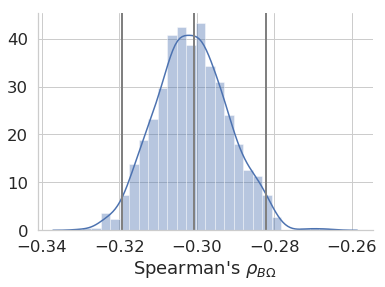

In [80]:
metric_percentiles, mean_metric = viz_percentiles(resampled_spearman_r)
plt.xlabel(r"Spearman's $\rho_{B\Omega}$")

### Variance Inflation Factor (VIF) & 95% CI

In [81]:
def compute_variance_inflation_factor(correlations):

    vifs = [(1 / (1 - r**2)) for r in correlations]

    return vifs

In [42]:
vifs = compute_variance_inflation_factor(resampled_spearman_r)

In [78]:
np.round(np.mean(vifs),3)

1.1

Text(0.5,0,'Variance Inflation Factor (VIF)')

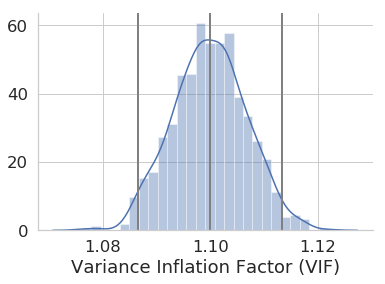

In [82]:
metric_percentiles, mean_metric = viz_percentiles(vifs)
plt.xlabel("Variance Inflation Factor (VIF)")

In [89]:
np.round(metric_percentiles,3),  np.round(mean_metric,3)

(array([1.113, 1.086]), 1.1)

In [90]:
np.round(mean_metric - metric_percentiles[0],3)

-0.013